# SVM random "forest"

We will take the top SVM models and try to throw them into a bagging classifier to see if we can improve the results.

In [4]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product

from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging
import pandas

%matplotlib inline

ld = LearningData()

In [5]:
stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.INFO)
stocks = [Utilities.orginizers.TrainingData(sn, ld=ld).add_history(10).set_threshold(0.8).get() for sn in stock_names]

INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=SHW, days_forward=1: threshold found is 0.018134653877025918
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=MNK, days_forward=1: threshold found is 0.026397640541565882
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 2  6 10 14 18 22 26 30 34 38 42 46 50 54 58 62 66 70 74 78] are constant.
  UserWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=BIO, days_forward=1: threshold found is 0.018548151336335694
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0
INFO:root:TrainingData: name=KYTH, days_forward=1: threshold found is 0

In [6]:
import os
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

SHW 7855
MNK 819
BIO 2343
KYTH 718
KRO 3220
             change        close         high           low          open  \
count  7.855000e+03  7855.000000  7855.000000  7.855000e+03  7.855000e+03   
mean   2.170977e-17     0.000000     0.000000 -1.447318e-16 -5.789272e-17   
std    1.000064e+00     1.000064     1.000064  1.000064e+00  1.000064e+00   
min   -9.826291e-01    -0.711964    -0.708525 -7.122042e-01 -7.116923e-01   
25%   -6.546142e-01    -0.545740    -0.546135 -5.453623e-01 -5.462650e-01   
50%   -2.623907e-01    -0.438244    -0.440260 -4.366827e-01 -4.393026e-01   
75%    3.430775e-01    -0.053682    -0.052620 -5.562959e-02 -5.251225e-02   
max    1.404981e+01     3.669051     3.637710  3.656416e+00  3.640592e+00   

       change1_days_before  close1_days_before  high1_days_before  \
count         7.855000e+03         7855.000000        7855.000000   
mean          2.170977e-17            0.000000           0.000000   
std           1.000064e+00            1.000064         

In [19]:
def run_model(model, stocks=stocks):
    scores = {}
    for sn, (data, classes) in zip(stock_names, stocks):
        scores[sn] = sum(cross_val_score(model, data, classes))/3
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

In [14]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
import traceback

# create iterables for all options and use itertools product
C=[0.4, 0.8, 1.2]
n_estimators=[10, 40, 100, 200]
max_samples=[0.2, 0.7]
max_features=[0.2, 0.4, 0.7]

bs_estimator_models = [BaggingClassifier(base_estimator=SVC(C=0.8, max_iter=1200), n_estimators=n) for n in n_estimators]
bs_c_models = [BaggingClassifier(base_estimator=SVC(C=c, max_iter=1200), n_estimators=40) for c in C]
bs_max_features_models = [BaggingClassifier(base_estimator=SVC(C=0.8, max_iter=1200), n_estimators=40, max_features=mf) for mf in max_features]
bs_max_samples_models = [BaggingClassifier(base_estimator=SVC(C=0.8, max_iter=1200), n_estimators=40, max_samples=ms) for ms in max_samples]


In [12]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bs_estimator_accuracies = list(map(run_model, bs_estimator_models))

In [15]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for tmodel, taccs in zip(bs_estimator_models, bs_estimator_accuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.n_estimators, tsn, tacc))
bs_estimator_results = DataFrame(data, columns=('n_estimators', 'stock', 'accuracy'))

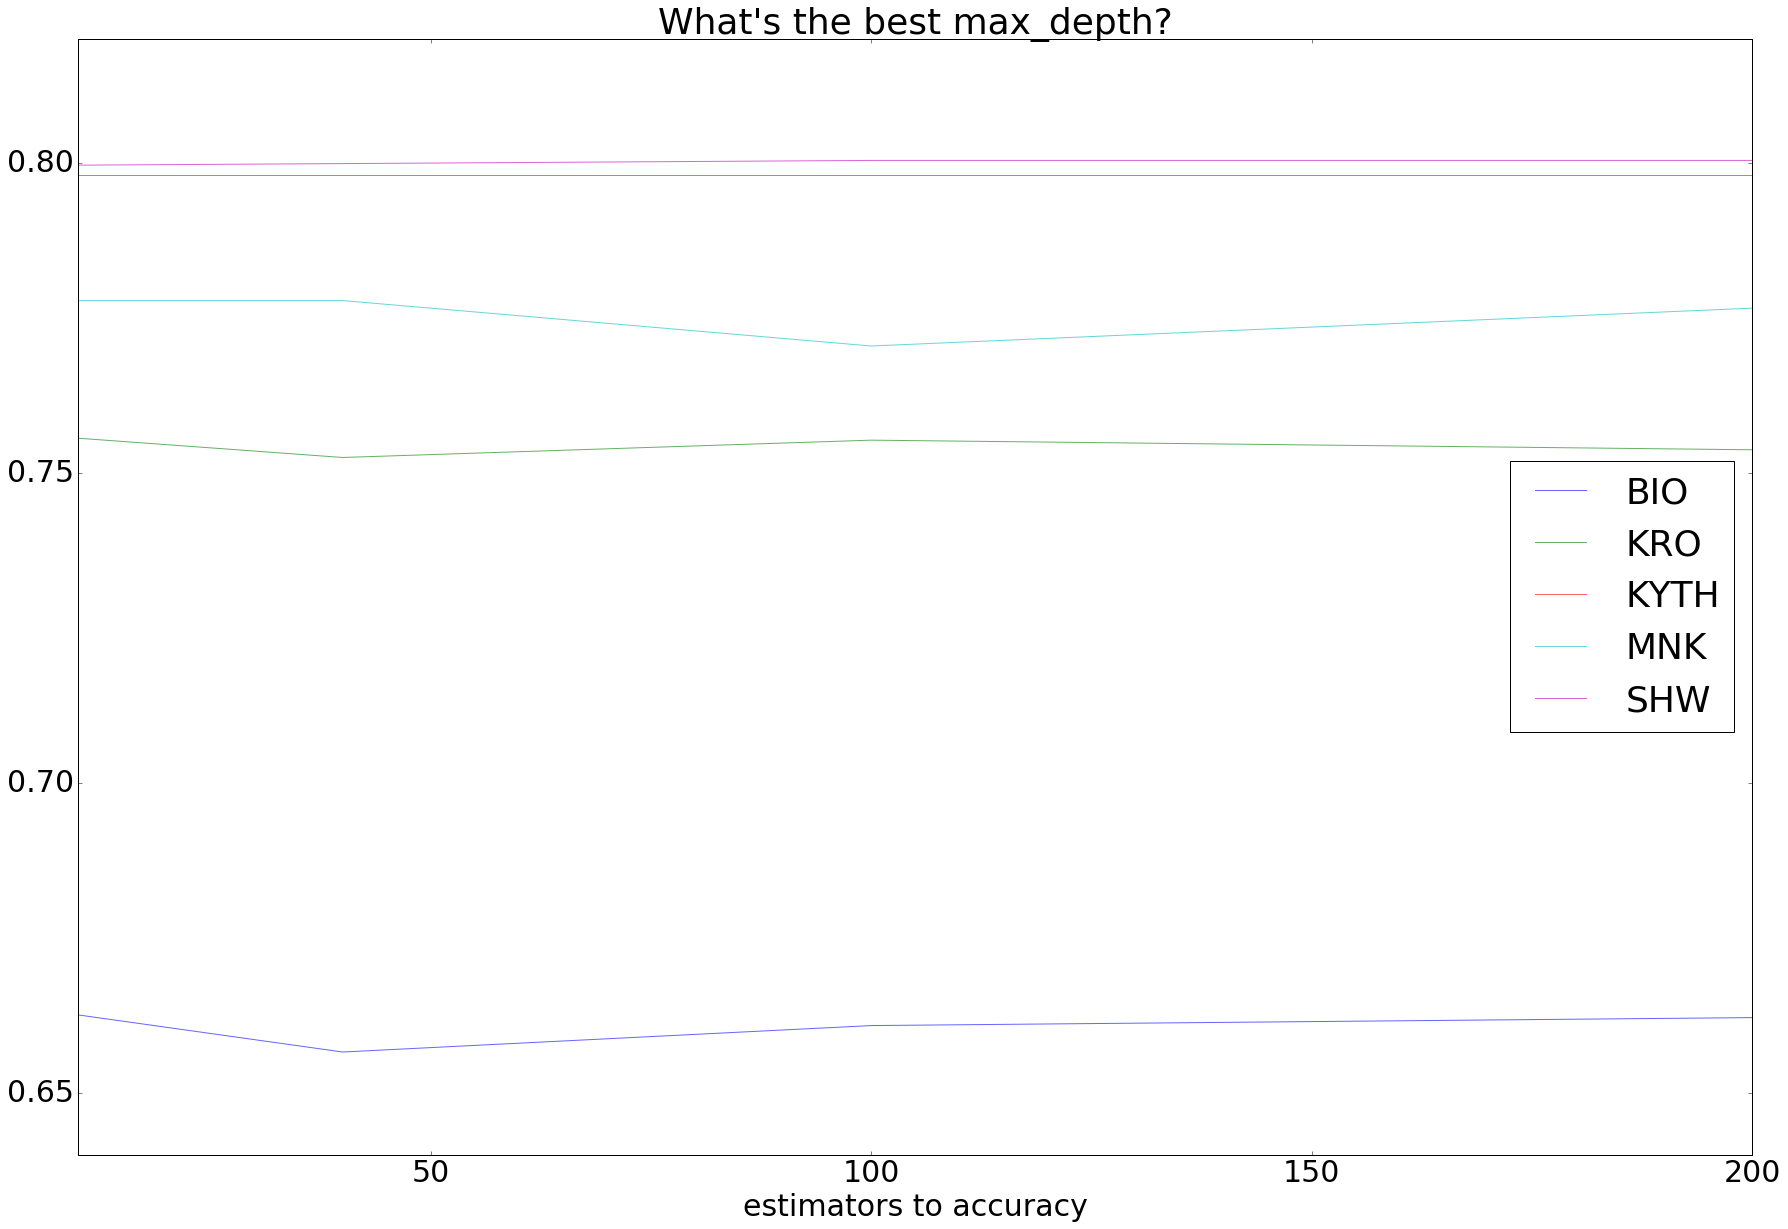

In [24]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in bs_estimator_results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('n_estimators').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('estimators to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

In [25]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bs_c_accuracies = list(map(run_model, bs_c_models))

In [27]:
data = []
for tmodel, taccs in zip(bs_c_models, bs_c_accuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.base_estimator.C, tsn, tacc))
bs_c_results = DataFrame(data, columns=('c', 'stock', 'accuracy'))

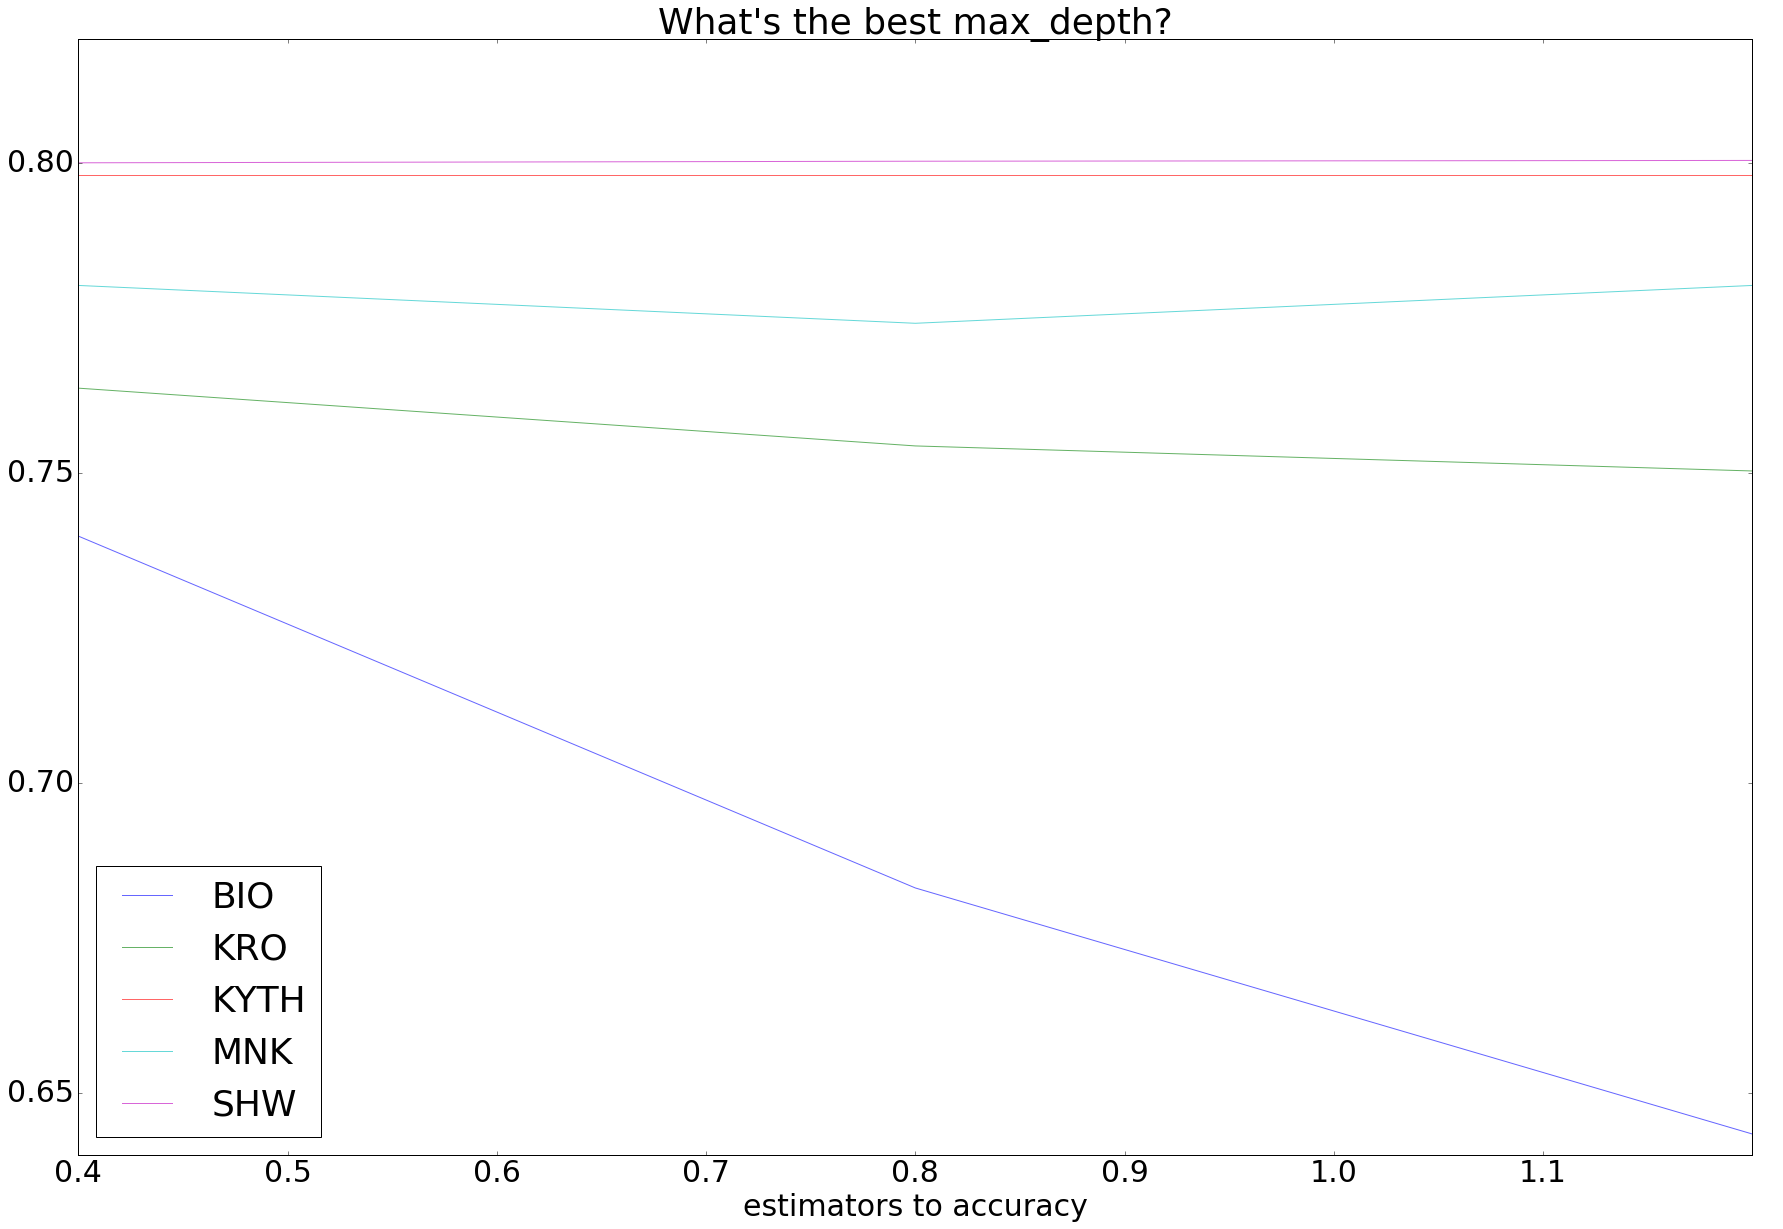

In [29]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in bs_c_results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('c').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('estimators to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

In [30]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bs_feat_accuracies = list(map(run_model, bs_max_features_models))

In [31]:
data = []
for tmodel, taccs in zip(bs_max_features_models, bs_feat_accuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.max_features, tsn, tacc))
bs_feat_results = DataFrame(data, columns=('features', 'stock', 'accuracy'))

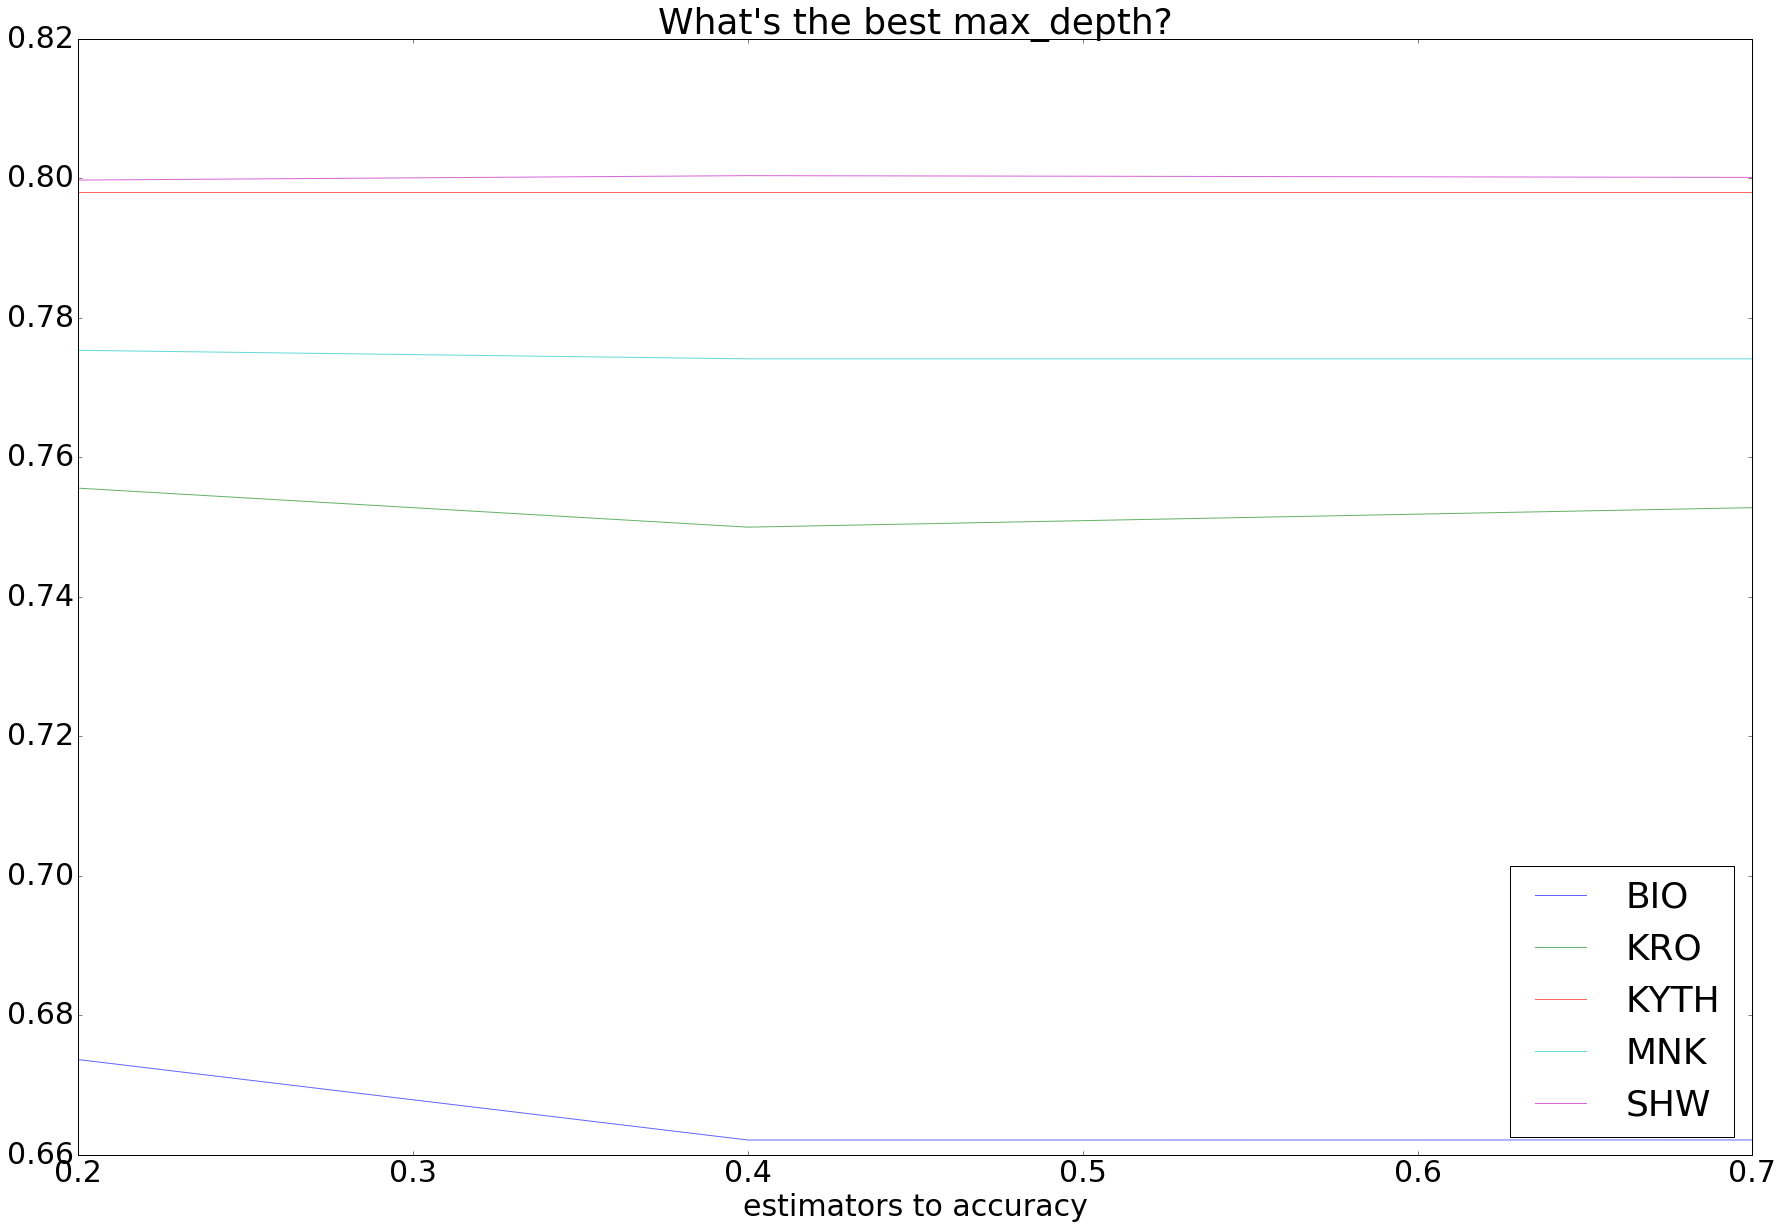

In [32]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in bs_feat_results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('features').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('estimators to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

In [33]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    bs_samp_accuracies = list(map(run_model, bs_max_samples_models))

In [34]:
data = []
for tmodel, taccs in zip(bs_max_samples_models, bs_samp_accuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.max_samples, tsn, tacc))
bs_max_samples_results = DataFrame(data, columns=('samples', 'stock', 'accuracy'))

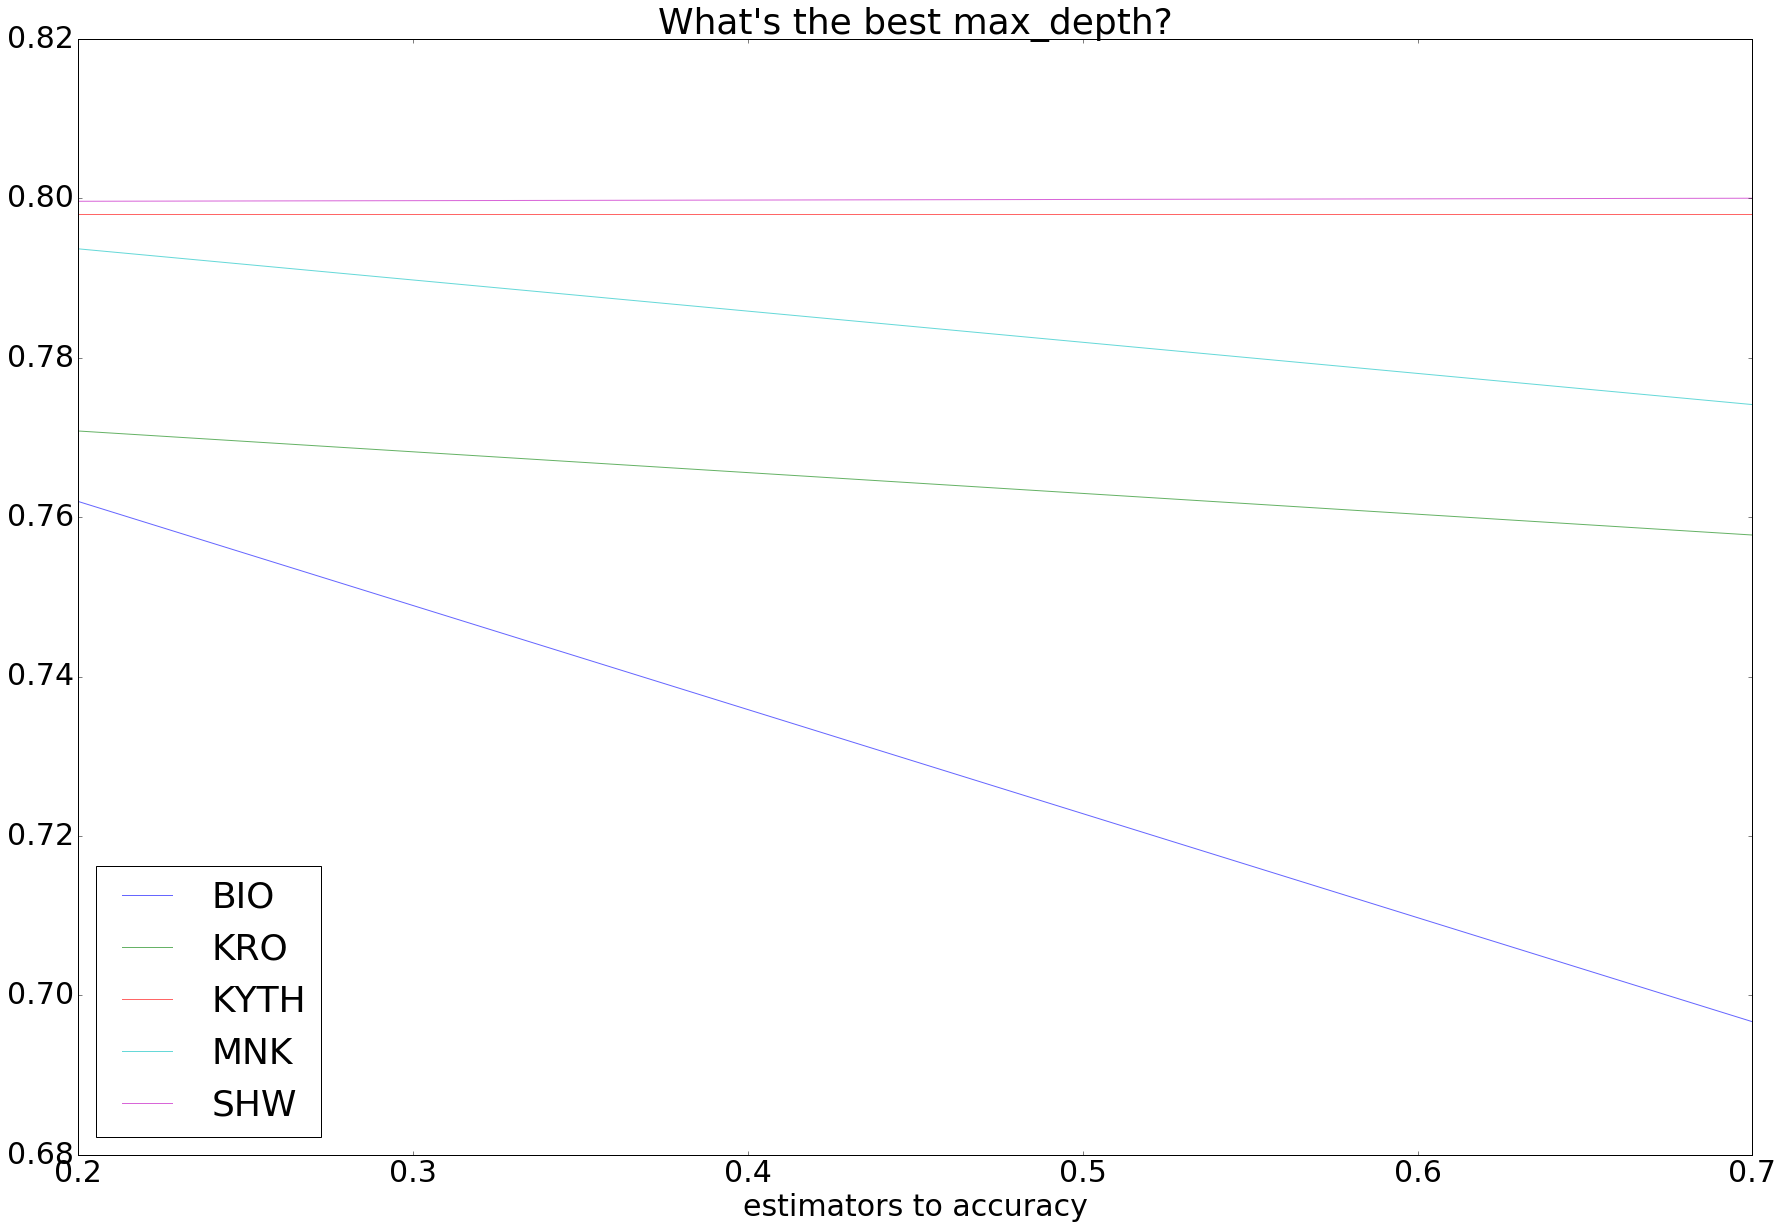

In [35]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in bs_max_samples_results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('samples').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('estimators to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

In [36]:
import pickle

pickle.dump((bs_estimator_accuracies, bs_c_accuracies, bs_feat_accuracies, bs_samp_accuracies),
           open('SVMBagging.p', 'wb'))